<a href="https://colab.research.google.com/github/ospinooo/mushsnap-research/blob/master/Tensorflow_custom_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Custom CNN

In this netbook we will research about the application of a simple ANN network built with a few layers to solve the problem of identification of poisonous mushrooms.

After we will try to use Data augmentation to train the model with more variety of examples.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

# Other imports
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import regularizers
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import EarlyStopping
from keras.callbacks import TensorBoard
from imutils import paths
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import random
import shutil
import time
import cv2
import os

Using TensorFlow backend.


# Data

As usual we have the data saved in our drive. So we conect the drive content and access the data. We decompress it an use it.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# Set variables
ZIP_FILENAME_DATASET="mushsnap_dataset_2020-04-20_11-04-43.tar.gz"
DRIVE_PATH= "drive/My Drive/"
TFG_PATH= DRIVE_PATH + "final project"
data_root = "data/data"

In [ ]:
# Decompress
!tar -xf drive/'My Drive'/'final project'/dataset/$ZIP_FILENAME_DATASET

In [ ]:
# Reading all paths
NUM_MIN = min(len(list(paths.list_images("dataset/edible"))), len(list(paths.list_images("dataset/poisonous"))))
print(NUM_MIN)

5367


In [ ]:
NUM_MIN = 2000
ALL_IMG_PATHS = list(paths.list_images("dataset/edible"))[:NUM_MIN] + list(paths.list_images("dataset/poisonous"))[:NUM_MIN]
ALL_IMG_PATHS = [i for i in ALL_IMG_PATHS if i.split("/")[2][0] != '.']
# Shuffle image paths and preview
random.seed(1)
random.shuffle(ALL_IMG_PATHS)
ALL_IMG_PATHS[:5]
print(f" Total number of images: {len(ALL_IMG_PATHS)}")

 Total number of images: 3999


In [ ]:
!rm -rf dataset/inedible

Visualize some images.

100%|██████████| 50/50 [00:01<00:00, 48.89it/s]


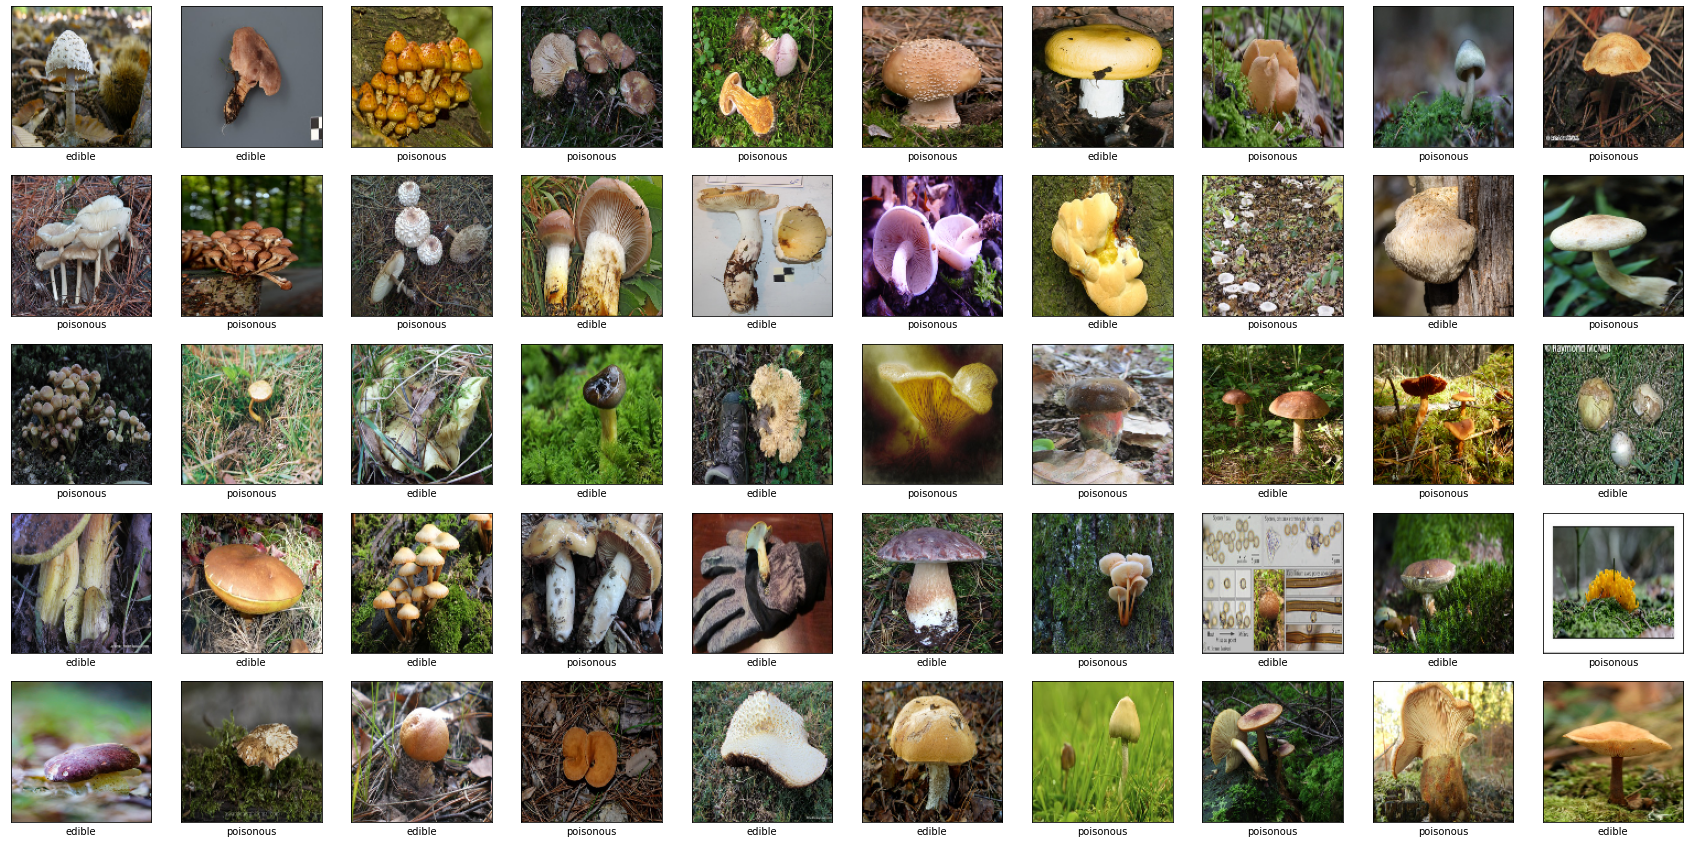

In [ ]:
# Visualize images
plt.figure(figsize=(30,15))
for i in tqdm(range(50)):
    image_path = np.random.choice(ALL_IMG_PATHS)
    image = plt.imread(image_path)
    image = cv2.resize(image, (128, 128))
    # you might want to verify the labels before 
    # you put this to use
    label = image_path.split("/")[1]
    plt.subplot(5,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(True)
    plt.imshow(image)
    plt.xlabel(label)
plt.show()

## Create subsets

Here we create the test and validation test from all the images we have.

1. First we calculate the sizes regarding its percentages.
2. Move the images to its corresponding folder.

In [ ]:
# Split
percentage_test = 0.05
percentage_val = 0.15

# Total images per subset
nb_val_images_i = int(len(ALL_IMG_PATHS) * percentage_val)
nb_test_images_i = int(len(ALL_IMG_PATHS) * percentage_test)
nb_train_images_i = len(ALL_IMG_PATHS) - (nb_val_images_i + nb_test_images_i)

# Create tuples extremes for each subset
nb_train_images = 0, nb_train_images_i
nb_val_images = nb_train_images_i, nb_train_images_i + nb_val_images_i
nb_test_images = nb_train_images_i + nb_val_images_i,  len(ALL_IMG_PATHS)


print(nb_train_images)
print(nb_val_images)
print(nb_test_images)

(0, 3201)
(3201, 3800)
(3800, 3999)


In [ ]:
# Specify the directory paths
train_dir = "train"
val_dir = "val"
test_dir = "test"

In [ ]:
def move_images(nb_images, output_dir):

    # iterate through the number of images
    for i in tqdm(range(*nb_images)):
        # grab an image path and grab the label of the image
        image_path = ALL_IMG_PATHS[i]
        # careful about the index of the split
        label = image_path.split("/")[1]
        
        # check if a directory for the label exists, if not create it
        new_image_dir = os.path.join(output_dir, label)
        if not os.path.exists(new_image_dir):
            os.makedirs(new_image_dir)
            
        # copy the current image to the respective folder
        shutil.copy2(image_path, new_image_dir)

In [ ]:
!rm -rf train
!rm -rf val
!rm -rf test

In [ ]:
# Prepare the train and test set
move_images(nb_train_images, train_dir)
move_images(nb_val_images, val_dir)
move_images(nb_test_images, test_dir)

100%|██████████| 199/199 [00:00<00:00, 3286.54it/s]


## Data augmentation

Once we have all images prepared in the train, val and test subsets we can start with the setup of the model. In the first step we will define the data augmentation mecanism we will use.

In [ ]:
batch_size = 128
epochs = 15
IMG_HEIGHT = 224
IMG_WIDTH = 224

In [ ]:
train_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data

In [ ]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')

Found 3201 images belonging to 2 classes.


In [ ]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=val_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary')

Found 599 images belonging to 2 classes.


In [ ]:
sample_training_images, _ = next(train_data_gen)

In [ ]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

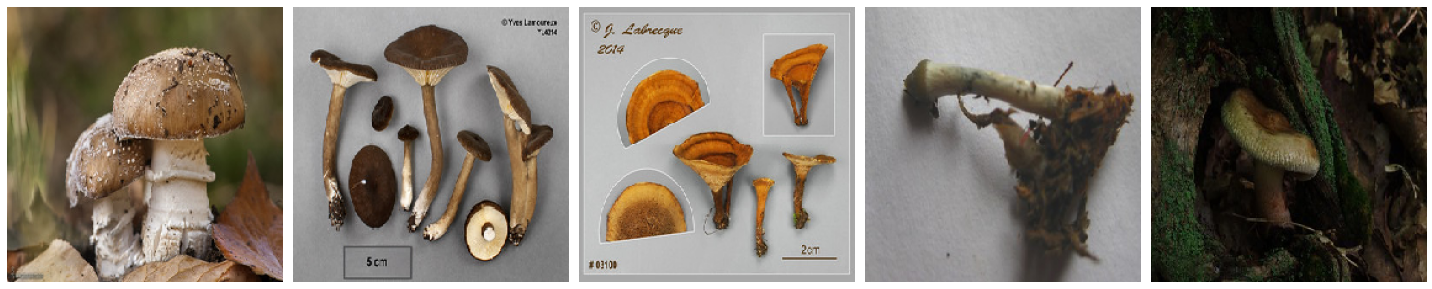

In [ ]:
plotImages(sample_training_images[:5])

# Model

We define the model

In [ ]:
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 50176)             0

In [ ]:
# train
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=3198 // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=599 // batch_size
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/15
24/24 [==============================] - 12s 518ms/step - loss: 1.1912 - accuracy: 0.5008 - val_loss: 0.6940 - val_accuracy: 0.5293
Epoch 2/15
24/24 [==============================] - 11s 459ms/step - loss: 0.6877 - accuracy: 0.5049 - val_loss: 0.6896 - val_accuracy: 0.5156
Epoch 3/15
24/24 [==============================] - 11s 464ms/step - loss: 0.6722 - accuracy: 0.5426 - val_loss: 0.7047 - val_accuracy: 0.5078
Epoch 4/15
24/24 [==============================] - 11s 463ms/step - loss: 0.6548 - accuracy: 0.5525 - val_loss: 0.6929 - val_accuracy: 0.5000
Epoch 5/15
24/24 [==============================] - 11s 467ms/step - loss: 0.6359 - accuracy: 0.5905 - val_loss: 0.7202 - val_accuracy: 0.5078
Epoch 6/15
24/24 [==============================] - 11s 466ms/step - loss: 0.6196 - accuracy: 0.5997 - val_loss: 0.7177 - val_accuracy: 0.5117
Epoch 7/15
24/24 [==============================] - 12s 483ms/step

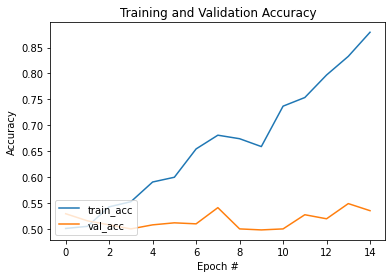

In [ ]:
# Plotting the losses
N = len(history.history["loss"])
plt.figure()
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")
plt.show()

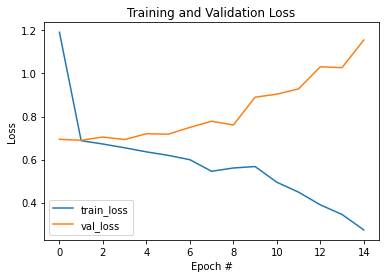

In [ ]:
# Plotting the losses
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.show()

## Overfitting

We see that our model overfits. It handles to fit the training data but it cannot generalize to the validation data. Let's add data augmentation into the model.

In [36]:
# Add data augmentation
train_image_generator = ImageDataGenerator(rescale=1./255 # Generator for our training data
                               , zoom_range=0.3
                               , rotation_range=40
                               , width_shift_range=0.2
                               , height_shift_range=0.2
                               , shear_range=0.2
                               , horizontal_flip=True
                               , fill_mode='nearest'
                               )

validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data

train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')

val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=val_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary')

model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

Found 3201 images belonging to 2 classes.
Found 599 images belonging to 2 classes.


In [37]:
# train
history = model.fit(
    train_data_gen,
    steps_per_epoch=3198 // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=599 // batch_size
)

Epoch 1/15
24/24 [==============================] - 42s 2s/step - loss: 0.9769 - accuracy: 0.5033 - val_loss: 0.6933 - val_accuracy: 0.5020
Epoch 2/15
24/24 [==============================] - 41s 2s/step - loss: 0.6940 - accuracy: 0.5070 - val_loss: 0.6965 - val_accuracy: 0.5039
Epoch 3/15
24/24 [==============================] - 41s 2s/step - loss: 0.6941 - accuracy: 0.5107 - val_loss: 0.6922 - val_accuracy: 0.5000
Epoch 4/15
24/24 [==============================] - 42s 2s/step - loss: 0.6923 - accuracy: 0.5066 - val_loss: 0.6952 - val_accuracy: 0.5137
Epoch 5/15
24/24 [==============================] - 41s 2s/step - loss: 0.6901 - accuracy: 0.5039 - val_loss: 0.6967 - val_accuracy: 0.4961
Epoch 6/15
24/24 [==============================] - 41s 2s/step - loss: 0.6909 - accuracy: 0.5080 - val_loss: 0.6953 - val_accuracy: 0.4980
Epoch 7/15
24/24 [==============================] - 41s 2s/step - loss: 0.6916 - accuracy: 0.5046 - val_loss: 0.7069 - val_accuracy: 0.5000
Epoch 8/15
24/24 [==

When we start adding data augmentation we realize that maybe the network architecture is not complex enough to fit the training data.

> Let's create new complex architectures.